In [1]:
import h5py, os
import numpy as np
from importlib import reload

import matplotlib.pyplot as plt
%matplotlib inline

from ecog.utils.electrodes import load_electrode_labels
from ecog.utils import bands
from ecog.tokenize.transcripts import parse, make_df
from ecog.signal_processing import zscore, gaussian, hilbert_transform

from cv_paper_plots import pipeline_analysis as analysis
from cv_paper_plots.pipeline_analysis import make_slice, make_colors, make_bracket

In [2]:
subj_path = os.path.join(os.environ['HOME'], 'Development/data/ecog/EC2')
block = 'EC2_B1'
block_path = os.path.join(subj_path, block)
rate = 400

anatomy = load_electrode_labels(subj_path)
vsmc_idxs = np.array([idx for idx, a in enumerate(anatomy) if a in ['preCG', 'postCG']])

ec2_b1_transcript_parse = parse(block_path, block)
ec2_b1_transcript = make_df(ec2_b1_transcript_parse, 1, 'EC2', 1)

In [3]:
with h5py.File(os.path.join(block_path, 'ecog400/ecog.h5')) as f:
    raw_vsmc_data = f['ecogDS/data'][sorted(vsmc_idxs)]
vsmc_data, means, stds = zscore(raw_vsmc_data, mode='file', sampling_freq=400., block_path=block_path)

In [4]:
cfs = bands.chang_lab['cfs']
stds = bands.chang_lab['sds']

minf, maxf = bands.neuro['min_freqs'][-1], bands.neuro['max_freqs'][-1]
filters = [gaussian(vsmc_data, rate, c, s) for c, s in zip(cfs, stds) if ((c >= minf) and (c <= maxf))]
ht = np.squeeze(abs(hilbert_transform(vsmc_data, rate, filters)))
print(ht.shape)
ht, m, s = zscore(ht, mode='file', sampling_freq=400., block_path=block_path)
ht = ht.mean(axis=0) / 2 

(7, 88, 258801)


In [5]:
temp_data = []
for ii in ec2_b1_transcript.index:
    temp_data.append(ht[:, make_slice(ii, ec2_b1_transcript, rate)])
temp_data = np.stack(temp_data)

In [6]:
_idx, elec_idx, _ = np.unravel_index(np.argmax(temp_data), temp_data.shape)
idx = ec2_b1_transcript.index[_idx]
channel_slice = slice(elec_idx-5, elec_idx+5)
sl = make_slice(idx, ec2_b1_transcript, rate)
cv_data = vsmc_data[:, sl]

# Electrodes by time

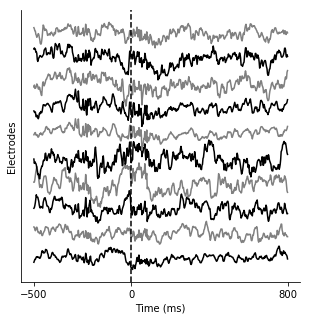

In [7]:
plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
analysis.plot_electrodes_by_time(cv_data[channel_slice], ax)
plt.savefig('/home/jesse/Downloads/electrodes.pdf')

# Bandpassed electrode

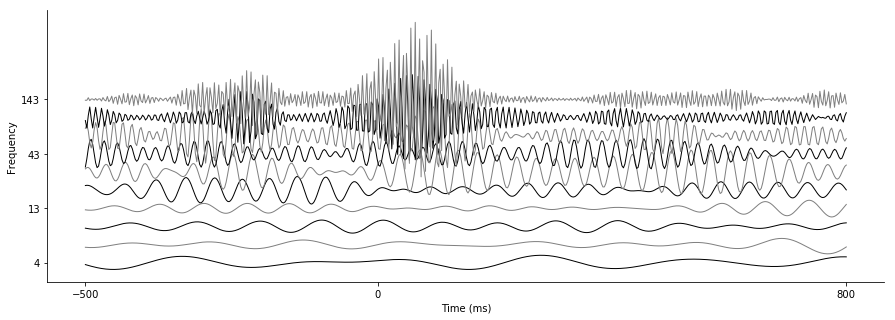

In [8]:
elec_data = vsmc_data[[elec_idx]]
band_idxs = np.arange(0, 40, 4)

plt.close()
f, ax = plt.subplots(1, figsize=(15, 5))
analysis.plot_40bands_by_time(elec_data, band_idxs, sl, rate, block_path, ax)
plt.savefig('/home/jesse/Downloads/frequencies.pdf')

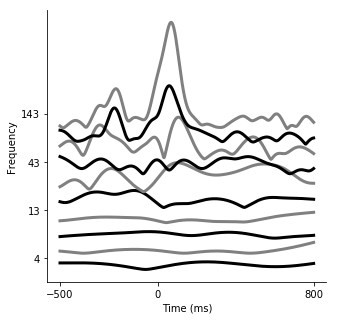

In [9]:
elec_data = vsmc_data[[elec_idx]]
band_idxs = np.arange(0, 40, 4)

plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
analysis.plot_40bandsAA_by_time(elec_data, band_idxs, sl, rate, block_path, ax)
plt.savefig('/home/jesse/Downloads/frequenciesAA.pdf')

# Neuro bands

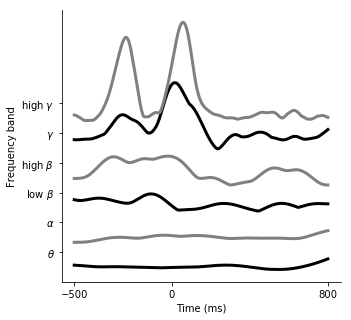

In [10]:
plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
analysis.plot_neurobands_by_time(elec_data, sl, rate, block_path, ax)
plt.savefig('/home/jesse/Downloads/bands.pdf')

# Dataset

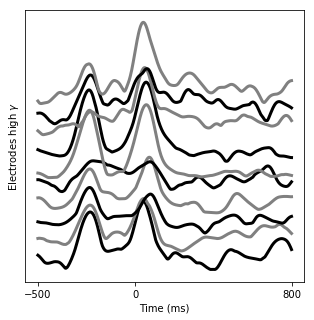

In [11]:
plt.close()
f, ax = plt.subplots(1, figsize=(5, 5))
analysis.plot_datapoints(vsmc_data[channel_slice], [sl], rate, block_path, [ax])
plt.savefig('/home/jesse/Downloads/data.pdf')

# Network

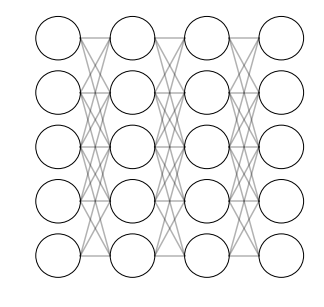

In [12]:
plt.close()
figsize = (5, 5)
f, ax = plt.subplots(1, figsize=figsize)
analysis.plot_network(5, 4, ax)
#plt.savefig('/home/jesse/Downloads/bands.pdf')

# Normal pipeline

0 1
0 1
0 1
0 1
0 1
0 1
0 1
0.225 1
0.1125 0.175
0 0.0625


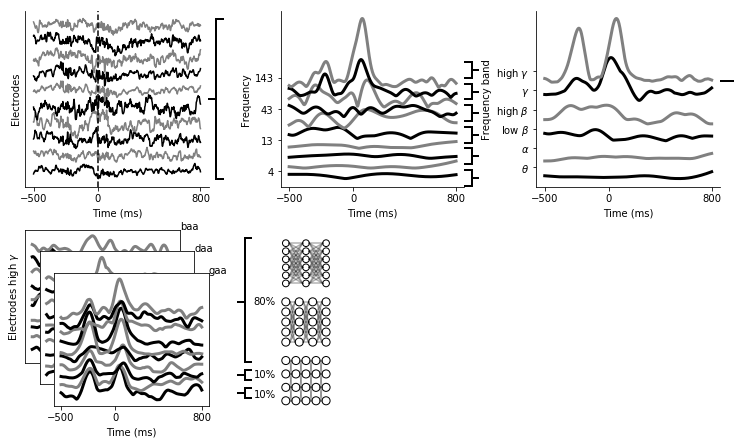

In [30]:
reload(analysis)
plt.close()
figsize = (10, 6)
x2y = figsize[0] / figsize[1]
f = plt.figure(figsize=figsize)

bot_gap = .075
top_gap = .01
l_gap = .025
r_gap = .01
h_gap = .1
v_gap = .1
height = (1. - bot_gap - v_gap - top_gap) / 2.
width = (1. - l_gap - 2* h_gap - r_gap) / 3.
y0 = bot_gap + height + v_gap
small_height = height / 3.5
width_square = small_height / x2y

ax0 = f.add_axes([l_gap, y0, width, height])
ax1 = f.add_axes([l_gap + width + h_gap, y0, width, height])
ax2 = f.add_axes([l_gap + 2 * width + 2 * h_gap, y0, width, height])


n_data = 3
data_axes = [f.add_axes([l_gap+(ii*.02), bot_gap + .1-(ii*.05), width - .04, height - .1]) for ii in range(n_data)]
for ii, t in zip(range(3), ['baa', 'daa', 'gaa']):
    f.text(l_gap + width - .04 + ii * .02, bot_gap + height - ii * .05, t)

axn0 = f.add_axes([l_gap + width + h_gap, bot_gap + height / 3., width_square, small_height])
axn1 = f.add_axes([l_gap + width + h_gap, bot_gap + 2 * height / 3., width_square, small_height])
axn2 = f.add_axes([l_gap + width + h_gap, bot_gap, width_square, small_height])

analysis.plot_electrodes_by_time(cv_data[channel_slice], ax0)
analysis.plot_40bandsAA_by_time(elec_data, band_idxs, sl, rate, block_path, ax1)
analysis.plot_neurobands_by_time(elec_data, sl, rate, block_path, ax2)
analysis.plot_datapoints(vsmc_data[channel_slice], [make_slice(idx, ec2_b1_transcript, rate) for idx in [2, 23, idx]],
                         rate, block_path, data_axes)
analysis.plot_network(5, 4, axn0)
analysis.plot_network(6, 3, axn1)
analysis.plot_network(4, 5, axn2)

bax0 = f.add_axes([l_gap + width, y0, .02, height])
make_bracket([.5], [0, 1], bax0)

x = l_gap + 2 * width + h_gap
y_t = y0
bax1_t = f.add_axes([x, y_t, .02, .04])
make_bracket([0, 1], [.5], bax1_t)
bax1_a = f.add_axes([x, y_t + .05, .02, .04])
make_bracket([0, 1], [.5], bax1_a)
bax1_lb = f.add_axes([x, y_t + 2*.05, .02, .04])
make_bracket([0, 1], [.5], bax1_lb)
bax1_hb = f.add_axes([x, y_t + 3*.05, .02, .04])
make_bracket([0, 1], [.5], bax1_hb)
bax1_g = f.add_axes([x, y_t + 4*.05, .02, .04])
make_bracket([0, 1], [.5], bax1_g)
bax1_hg = f.add_axes([x, y_t + 5*.05, .02, .04])
make_bracket([0, 1], [.5], bax1_hg)

x = l_gap + 3 * width + 2 * h_gap
ax_select = f.add_axes([x, y0, .02, height])
y = .6
ax_select.plot([0, 1], [y, y], 'k', lw=2)
ax_select.set_ylim(0, 1)
ax_select.axis('off')

cv_ax = f.add_axes([l_gap + width + h_gap / 2.5, bot_gap, .02, height])
make_bracket([.6], [.225, 1], cv_ax)
make_bracket([(.1125 + .175) / 2.], [.1125, .175], cv_ax)
make_bracket([.0625 / 2.], [0, .0625], cv_ax)
f.text(.3425, .31, '80%')
f.text(.3425, .14, '10%')
f.text(.3425, .095, '10%')

plt.savefig('/home/jesse/Downloads/normal_pipeline.pdf')